In [1]:
#!pip install shapely -U
#!pip install lyft-dataset-sdk

In [2]:
#DATASET_VERSION = 'v1.0'
DATASET_ROOT = '/home/keceli/samplelyft/'
ARTIFACTS_FOLDER = "./artifacts"

In [3]:
import os
import gc
import numpy as np
import pandas as pd

import json
from pprint import pprint
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List
from IPython.display import HTML, Image

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image
from collections import defaultdict

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

#Load the  Lyft SDK packages
from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [4]:
!ln -s /home/keceli/samplelyft/train_images images
!ln -s /home/keceli/samplelyft/train_lidar lidar

ln: failed to create symbolic link 'images/train_images': File exists
ln: failed to create symbolic link 'lidar/train_lidar': File exists


In [5]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
train_dataset = LyftDataset(data_path='.', json_path='/home/keceli/samplelyft/train_data/', verbose=True)

9 category,
18 attribute,
4 visibility,
129 instance,
10 sensor,
10 calibrated_sensor,
632 ego_pose,
180 log,
1 scene,
126 sample,
1260 sample_data,
7062 sample_annotation,
1 map,
Done loading in 0.1 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [6]:
keep_record = [(train_dataset.get('sample', record['first_sample_token'])['timestamp'], record) for keeprec in
        train_dataset.scene]

nList = []

for start_time, record in sorted(keep_record):
    start_time = train_dataset.get('sample', record['first_sample_token'])['timestamp'] / 1000000
    
    token_log = record['token']
    name_log = record['name']
    date_log = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    nList.append((host, name_log, date_log, token_log, first_sample_token))
            
df = pd.DataFrame(nList, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [8]:
num_of_hosts = df.groupby("host")['scene_token'].count()
print(num_of_hosts)

host
host-a101    1
Name: scene_token, dtype: int64


In [9]:
val_hosts = ["host-a101"]

val_df = df[df["host"].isin(val_hosts)]
vi = val_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(val_df), "train and val number")

0 1 train/validation split scene counts


In [10]:
sample_token = train_df.first_sample_token.values[0]
sample = train_dataset.get("sample", sample_token)

lidar_tok = sample["data"]["LIDAR_TOP"]
lidar_data = train_dataset.get("sample_data", lidar_tok)
lidar_path = train_dataset.get_sample_data_path(lidar_tok)

ego_pose_vec = train_dataset.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = train_dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation from car to world frame.
global_from_car = transform_matrix(ego_pose_vec['translation'],
                                   Quaternion(ego_pose_vec['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)

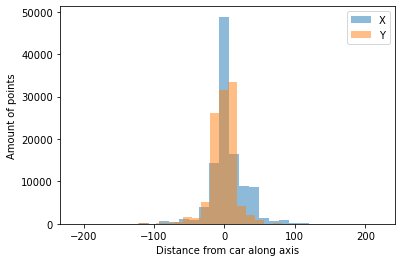

In [11]:
lidar_pc = LidarPointCloud.from_file(lidar_path)

lidar_pc.transform(car_from_sensor)

plt.hist(lidar_pc.points[0], alpha=0.3, bins=50, label="X")
plt.hist(lidar_pc.points[1], alpha=0.3, bins=50, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis way")
plt.ylabel("Number of Point Cloud")
plt.show()

In [12]:
map_mask = train_dataset.map[0]["mask"]

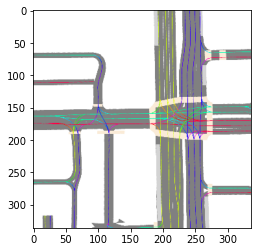

In [13]:
def get_semantic_map(map_mask, ego_pose_vec, voxel_size, output_shape):

    def crop_image(image: np.array,
                           x_px_limit: int,
                           y_px_limit: int,
                           axes_limit: int) -> np.array:
                x_min = int(x_px_limit - axes_limit)
                x_max = int(x_px_limit + axes_limit)
                y_min = int(y_px_limit - axes_limit)
                y_max = int(y_px_limit + axes_limit)

                cropped_image = image[y_min:y_max, x_min:x_max]

                return cropped_image

    pixel_coords = map_mask.to_pixel_coords(ego_pose_vec['translation'][0], ego_pose_vec['translation'][1])

    extent_size = voxel_size*output_shape[0]*0.5
    scaled_limit_pixel = int(extent_size * (1.0 / (map_mask.resolution)))
    mask_rast = map_mask.mask()

    cropped = crop_image(mask_rast, pixel_coords[0], pixel_coords[1], int(scaled_limit_pixel * np.sqrt(2)))

    ypr_rad = Quaternion(ego_pose_vec['rotation']).yaw_pitch_roll
    yaw_degree = -np.degrees(ypr_rad[0])

    rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_degree))
    ego_centric_map = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2,
                                 scaled_limit_pixel)[::-1]
    
    ego_centric_map = cv2.resize(ego_centric_map, output_shape[:2], cv2.INTER_NEAREST)
    return ego_centric_map.astype(np.float32)/255
    
ego_centric_map = get_semantic_map(map_mask, ego_pose_vec, voxel_size=0.4, output_shape=(336,336)) 
plt.imshow(ego_centric_map)
plt.show()

We voxelize the LiDAR point cloud data. So that, we will go with coordinate points of X, Y and Z.

In [14]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):

    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    trans_mat = np.eye(4, dtype=np.float32)
    t = shape/2 + offset/voxel_size
    
    trans_mat = trans_mat * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(t)
    return tm

def transform_points(points, transf_matrix):
    if points.shape[0] not in [3,4]:
        raise Exception("Invalid points shape. Input should be (3,N) or (4,N), received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

# Let's try it with some example values
tm = create_transformation_matrix_to_voxel_space(shape=(100,100,4), voxel_size=(0.5,0.5,0.5), offset=(0,0,0.5))
point = transform_points(np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32), tm)
print(point)

[[70. 70. 50. 50. 50.]
 [70. 60. 50. 50. 50.]
 [ 3.  3.  3.  7.  3.]]


In [15]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3D (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Invalid points shape. Input should be (3,N) or (4,N), found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    voxel_cord = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    voxel_cord = voxel_cord[:3].transpose(1,0)
    voxel_cord = np.int0(voxel_cord)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    bounds = (np.all(voxel_cord >= 0, axis=1) * np.all(voxel_cord < bev_shape, axis=1))
    
    voxel_cord = voxel_cord[bounds]
    coord, count = np.unique(voxel_cord, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
bev = normalize_voxel_intensities(bev)

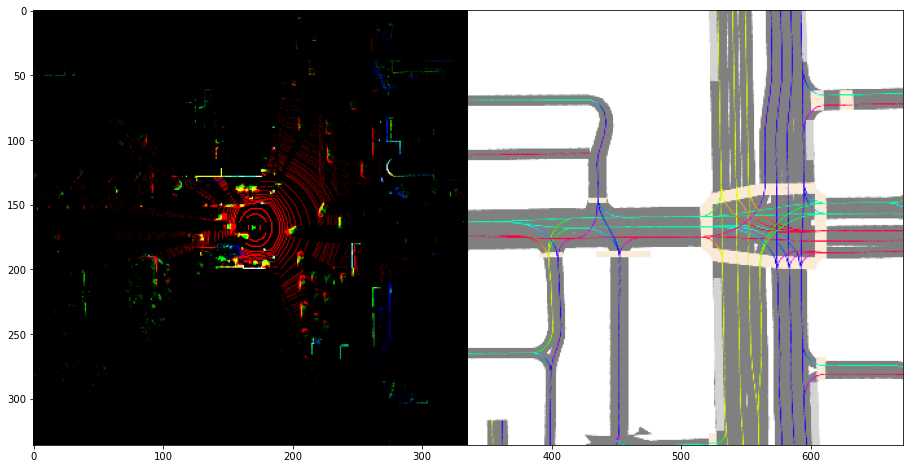

In [17]:
plt.figure(figsize=(16,8))
plt.imshow(np.hstack((bev, ego_centric_map)))
plt.show()

Above is the sample bev scene what the network look like. It's the visual world of the ego vehicle. Height of the lidar points represented in three bins, that visualized like the RGB channales of the image.

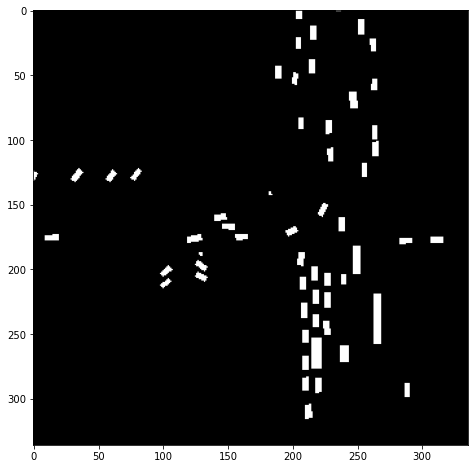

In [18]:
boxes = train_dataset.get_boxes(lidar_tok)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose_vec):
    translation = -np.array(ego_pose_vec['translation'])
    rotation = Quaternion(ego_pose_vec['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class name: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)



move_boxes_to_car_space(boxes, ego_pose_vec)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()

These are the annoted frame, In below we plot the same scene by using Lyft SDK. 

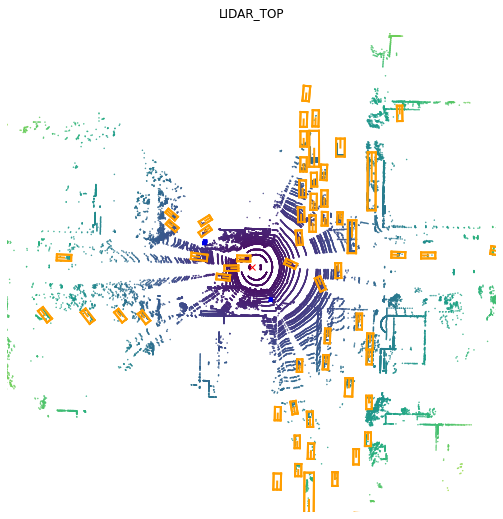

In [19]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = train_dataset.get("sample", sample_token)
    lidar_tok = sample["data"]["LIDAR_TOP"]
    train_dataset.render_sample_data(lidar_tok, axes_limit=axes_limit)
visualize_lidar_of_sample(sample_token)

Now it is ready to run train and validation set, we will assign target images into respective folders.

In [ ]:
#del bev, lidar_pointcloud, boxes

In [20]:
# Some hyperparameters
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# Scale down each box so they are more separated when projected into  voxel space.
box_scale = 0.8

In [21]:
train_data_path = os.path.join(ARTIFACTS_FOLDER, "bev_training_data")
validation_data_path = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

In [22]:
NUM_WORKERS = os.cpu_count() * 3

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = train_dataset.get("sample", sample_token)

        lidar_tok = sample["data"]["LIDAR_TOP"]
        lidar_data = train_dataset.get("sample_data", lidar_tok)
        lidar_path = train_dataset.get_sample_data_path(lidar_tok)

        ego_pose_vec = train_dataset.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = train_dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose_vec['translation'],
                                           Quaternion(ego_pose_vec['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_path)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = train_dataset.get_boxes(lidar_tok
                                       )

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose_vec)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        
        sample_token = sample["next"]

for df, data_folder in [(val_df, train_data_path), (train_df, validation_data_path)]:
    print("Preparing data into to {} path, using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values

    os.makedirs(data_folder, exist_ok=True)
    
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()
    del pool

Preparing data into ./artifacts/bev_train_data using 24 workers


<ipython-input-22-89f9f0290510>:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):



Preparing data into ./artifacts/./bev_validation_data using 24 workers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


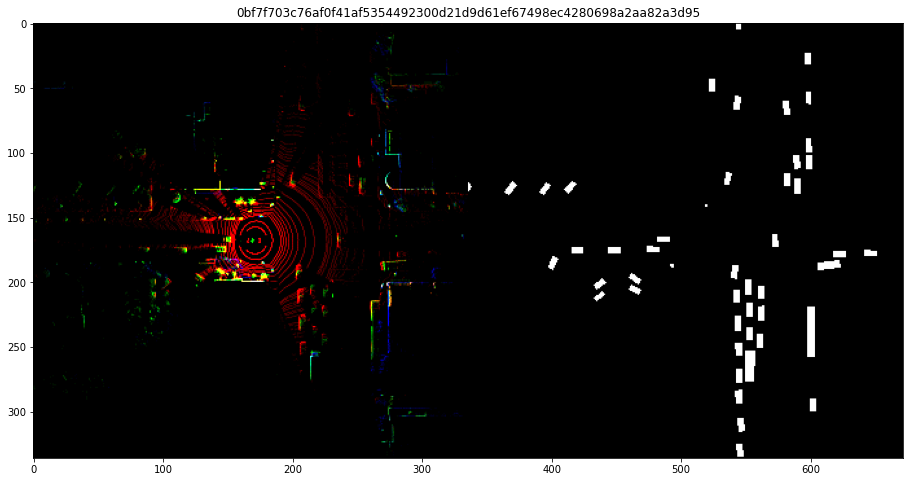

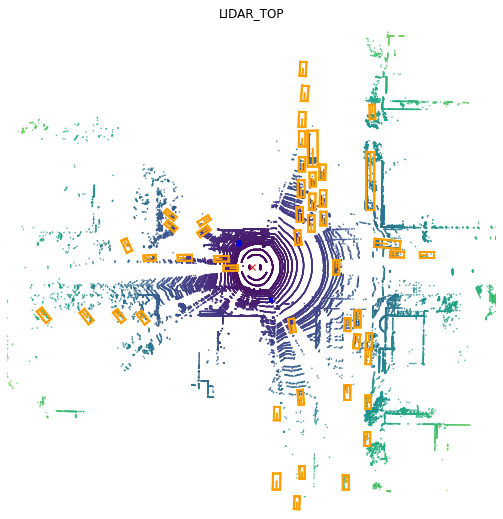

In [28]:
class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_file_paths, target_file_paths, map_file_path=None):
        self.input_file_paths = input_file_paths
        self.target_file_paths = target_file_paths
        self.map_file_path = map_file_path
        
        if map_file_path is not None:
            assert len(input_file_paths) == len(map_file_path)
        
        assert len(input_file_paths) == len(target_file_paths)

    def __len__(self):
        return len(self.input_file_paths)

    def __getitem__(self, idx):
        input_file_paths = self.input_file_paths[idx]
        target_filepath = self.target_file_paths[idx]
        
        sample_token = input_file_paths.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_file_paths, cv2.IMREAD_UNCHANGED)
        
        if self.map_file_path:
            map_file_path = self.map_file_path[idx]
            map_im = cv2.imread(map_file_path, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target_var = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target_var = target_var.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target_var = torch.from_numpy(target_var)
        
        return im, target_var, sample_token

input_file_paths = sorted(glob.glob(os.path.join(train_data_path, "*_input.png")))
target_file_paths = sorted(glob.glob(os.path.join(train_data_path, "*_target.png")))

train_dataset = BEVImageDataset(input_file_paths, target_file_paths)
    
im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb = np.repeat(target[...,None], 3, 2)

plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

In [29]:
# This implementation based from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

We will train the dataset with U-net FCNN. 
We will create U-net FCNN only half amount of the filters compared to U-net original paper.

In [30]:
def unet_model(in_channels=4, num_output_classes=2):
    model_unet = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=6, depth=3, padding=True, up_mode='upsample')
    model_unet = nn.DataParallel(model_unet)
    return model_unet

In [31]:
def visualize_predictions(input_image, prediction_image, target_image, n_images=2, apply_softmax=True):

    # Select first n images
    prediction_image = prediction_image[:n_images]
    target_image = target_image[:n_images]
    input_image = input_image[:n_images]

    prediction_image = prediction_image.detach().cpu().numpy()
    if apply_softmax:
        prediction_image = scipy.special.softmax(prediction_image, axis=1)
    class_one_preds = np.hstack(1-prediction_image[:,0])

    target_image = np.hstack(target_image.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target_image

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3: # Without semantic map input
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:] #Semantic map input
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,24))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [32]:
# Specifiy like below one if you have GPU, I haven't during the time, so torch device is cpu.
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
c_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
c_weights = c_weights.to(device)

Epoch 1


/home/keceli/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-33-ad57a026dbc7>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(dataloader)


/home/keceli/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


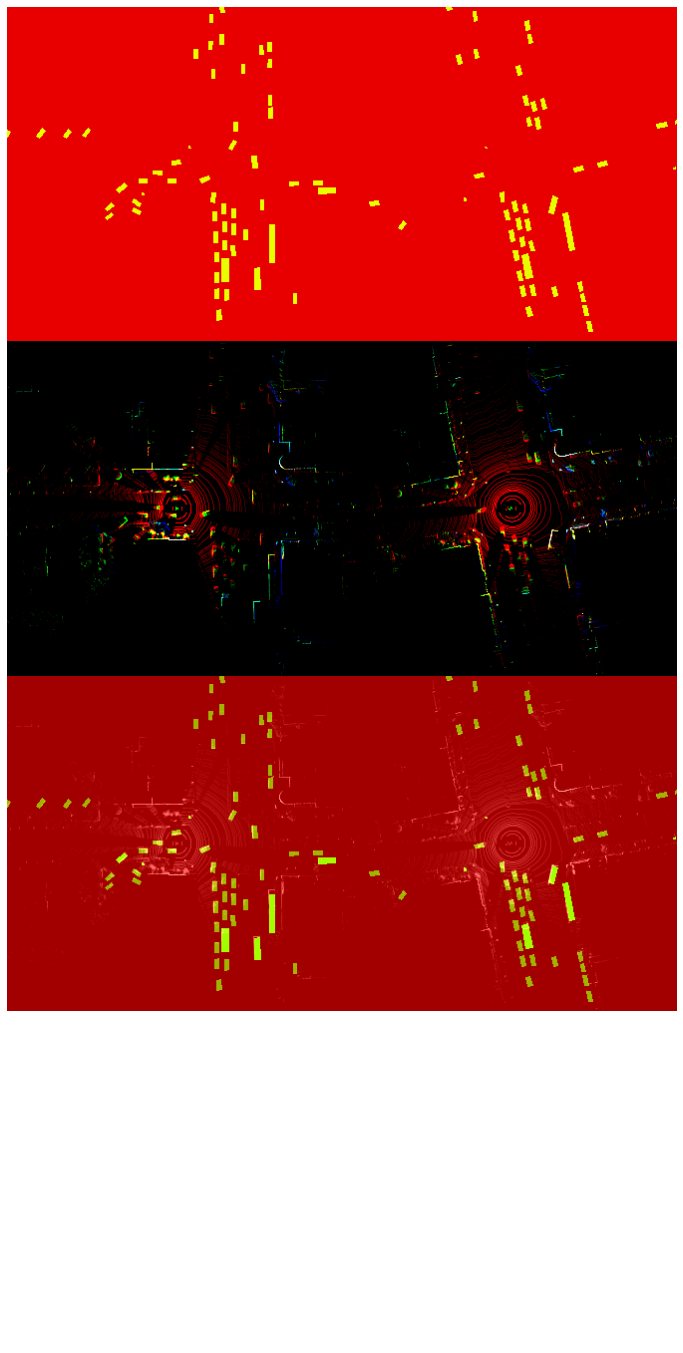


Loss: 1.4643946
Epoch 2


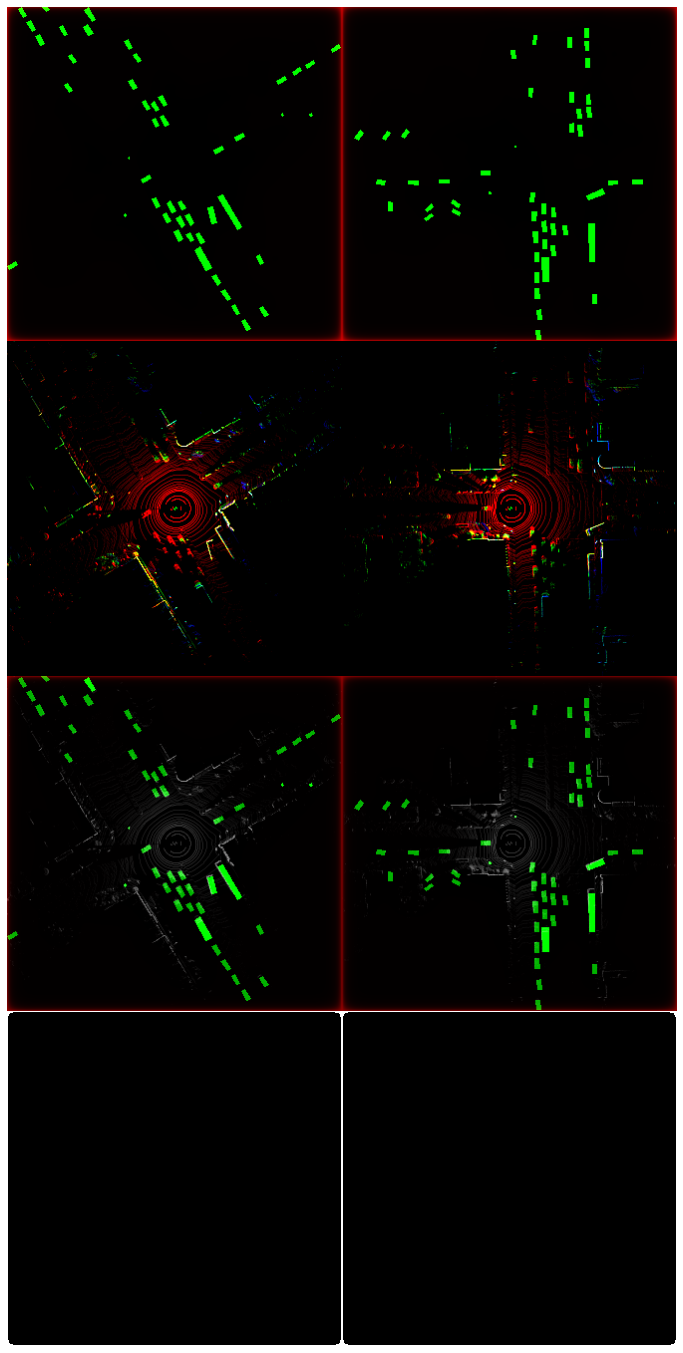


Loss: 0.5059575
Epoch 3


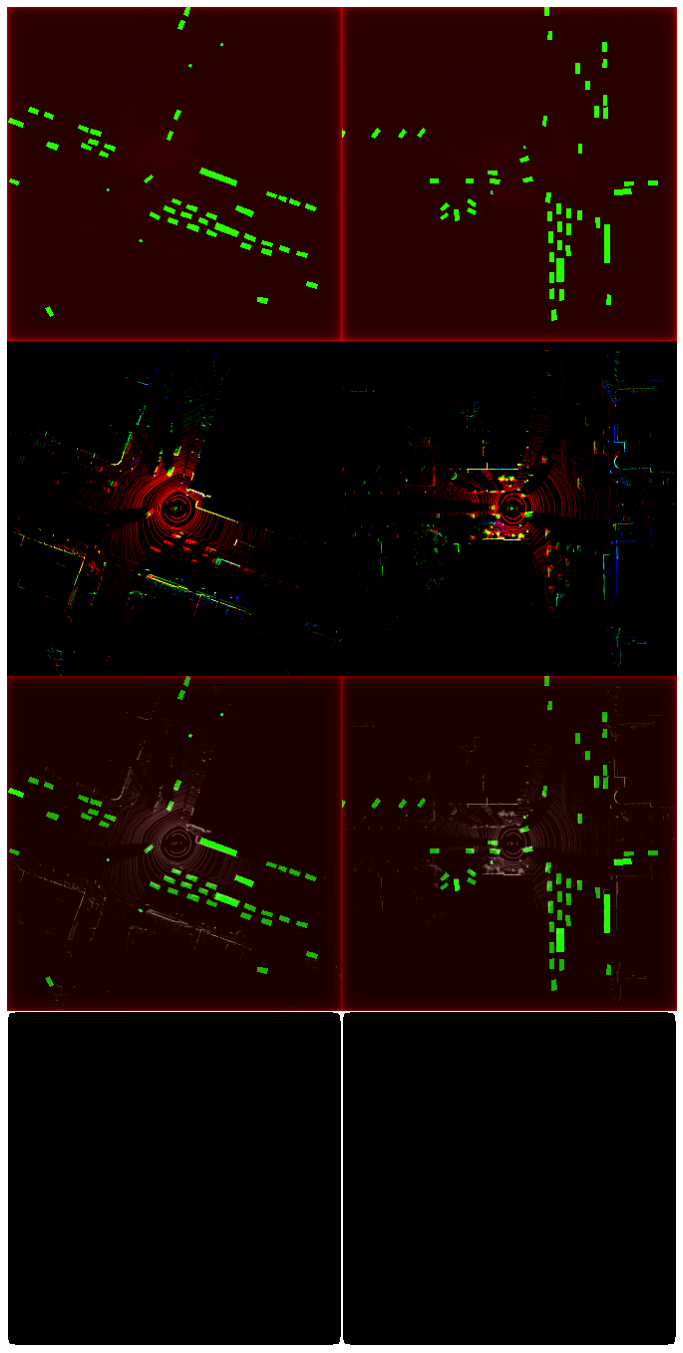


Loss: 0.43167633
Epoch 4


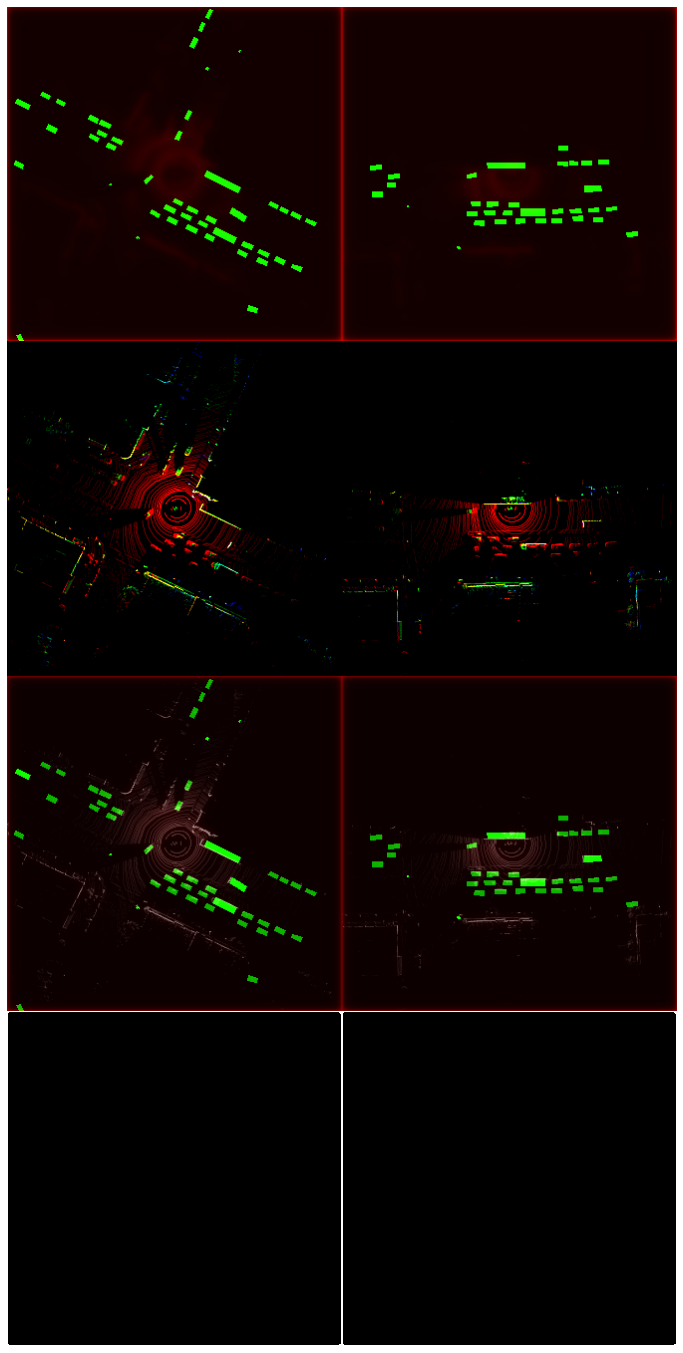


Loss: 0.40567598
Epoch 5


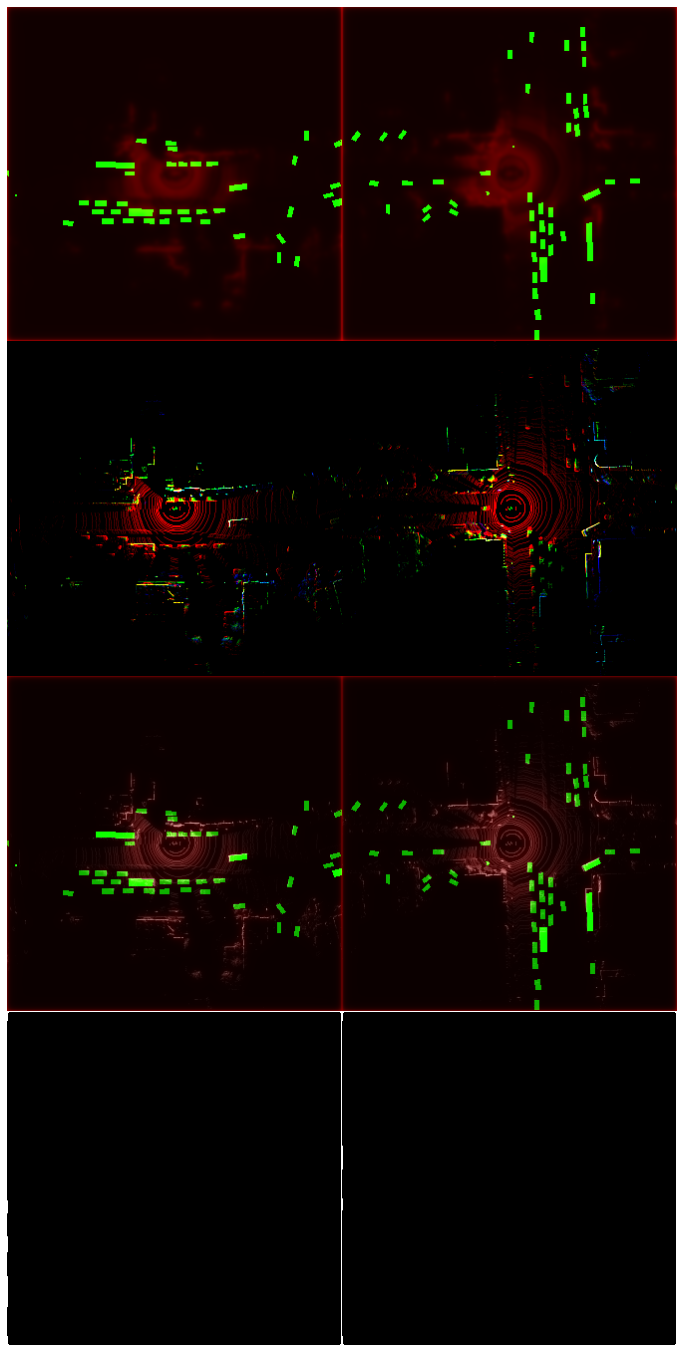


Loss: 0.38182676
Epoch 6


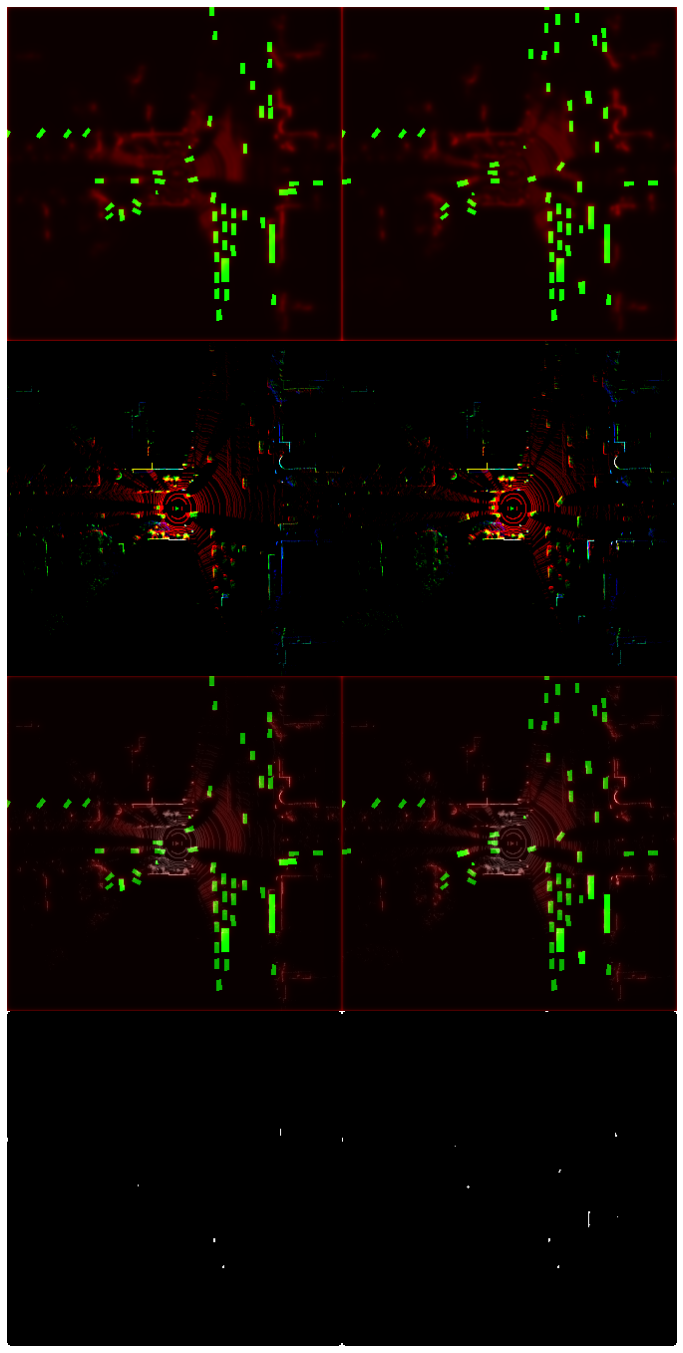


Loss: 0.35195714
Epoch 7


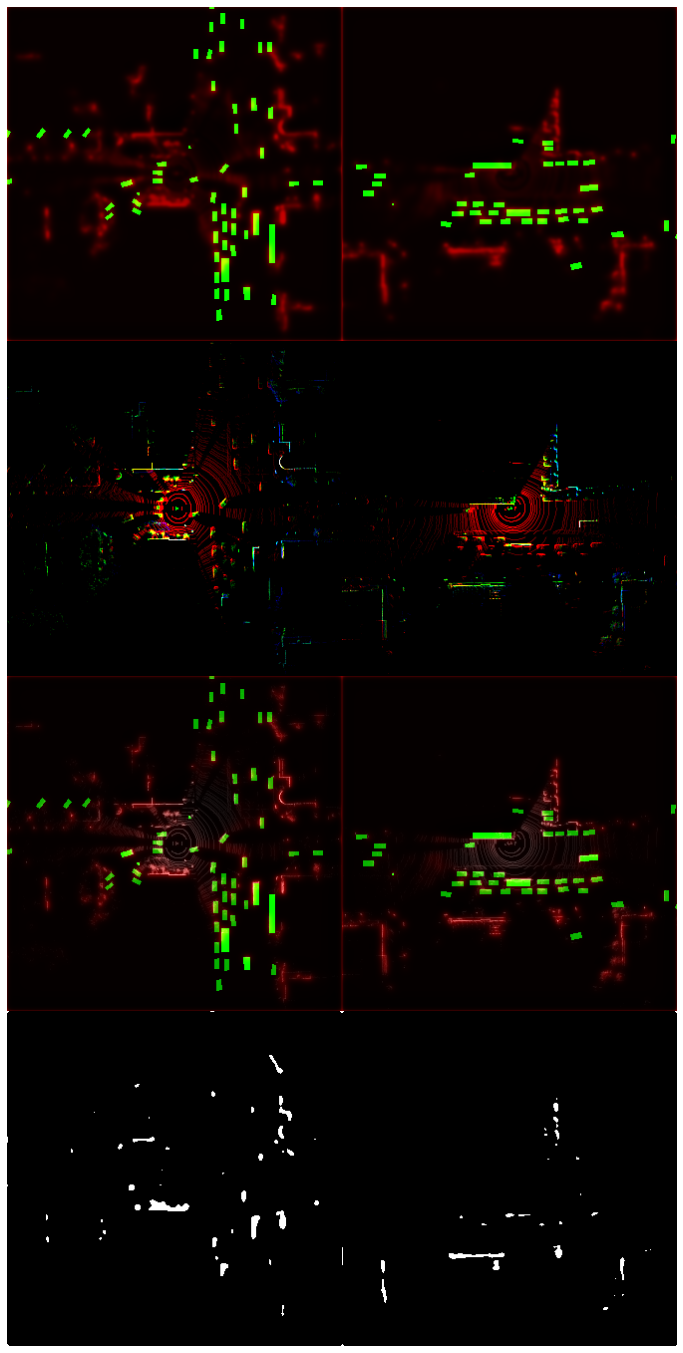


Loss: 0.33235276
Epoch 8


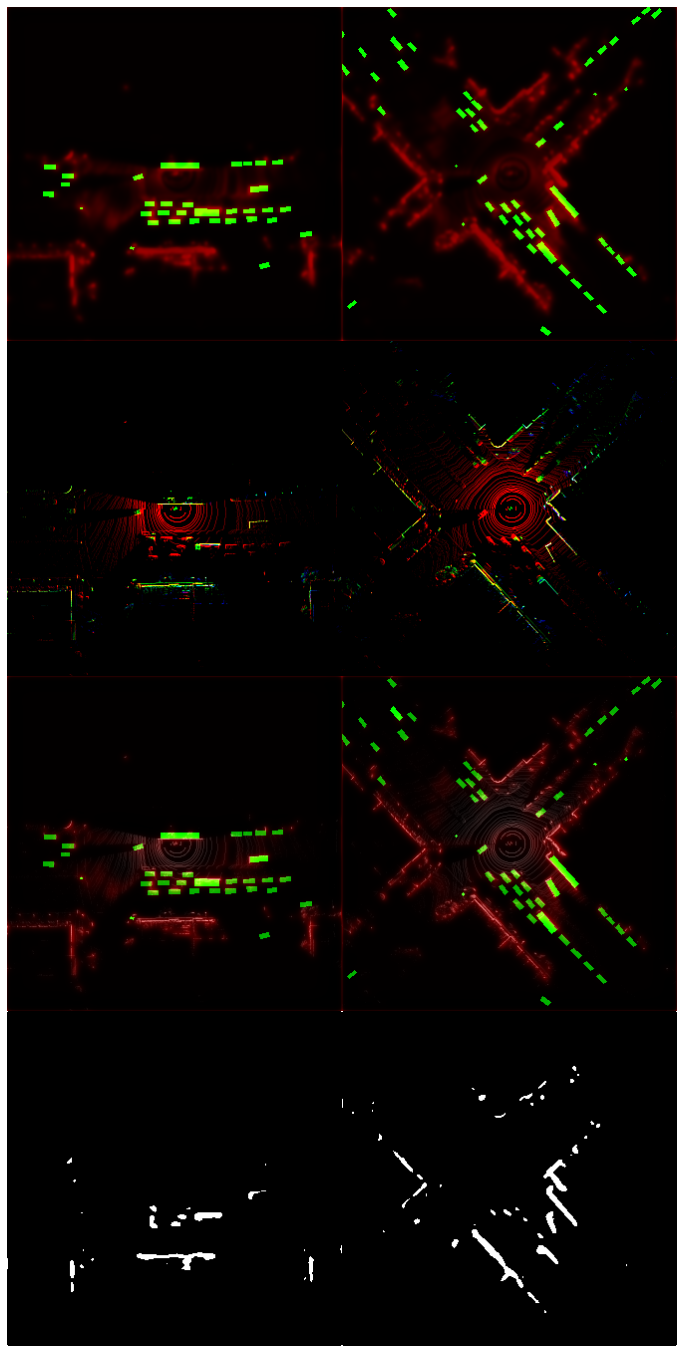


Loss: 0.31997657


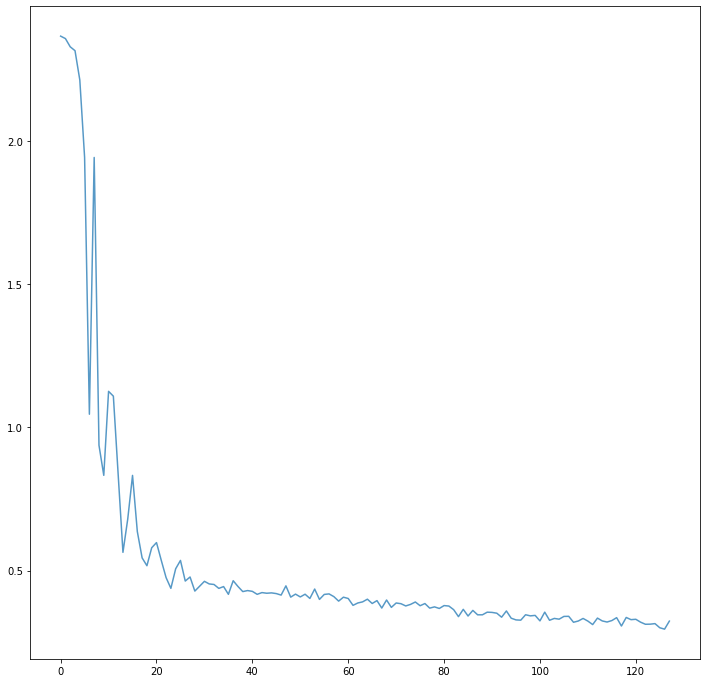

In [33]:
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short. because of the limited time.

unet_model_pred = unet_model(num_output_classes=len(classes)+1)
unet_model_pred = unet_model_pred.to(device)

optim = torch.optim.Adam(unet_model_pred.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)

all_losses = []

for num_of_epoch in range(1, epochs+1):
    print("Epoch", num_of_epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  
        target = target.to(device) 
        prediction = unet_model_pred(X)
        loss = F.cross_entropy(prediction, target, weight=c_weights)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target)
    
    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)
    
    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(num_of_epoch)
    checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
    torch.save(unet_model_pred.state_dict(), checkpoint_filepath)
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75)
plt.show()

#### Some insights about the above visualizations:  
There are four different visualizations stacked on top of eachother:
1. The top images have two color channels: red one is represent the predicted ones, green for ground truth(target), with red+green=yellow. In Confusion matrix manner is follows:  
> **Black**: True Negative  
> **Green**: False Negative  
> **Yellow**: True Positive  
> **Red**: False Positive 
2. The input raw image
3. The semantic input map created with targets+predictions
4. The predictions thresholded at 0.5.

## Inference and Postprocess Visualization 

In [54]:
input_file_paths = sorted(glob.glob(os.path.join(validation_data_path, "*_input.png")))
target_file_paths = sorted(glob.glob(os.path.join(validation_data_path, "*_target.png")))
#map_file_path = sorted(glob.glob(os.path.join(validation_data_path, "*_map.png"))) #Omitted for this one

batch_size=16
validation_dataset = BEVImageDataset(input_file_paths, target_file_paths, map_file_path)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

# Specifiy like below one if you have GPU, I haven't during the time, so torch device is cpu.
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = unet_model(num_output_classes=1+len(classes))
model = model.to(device)

epoch_to_load=8
checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_filepath))

<All keys matched successfully>

In [55]:
progress_bar = tqdm_notebook(validation_dataloader)

targets = np.zeros((len(target_file_paths), 336, 336), dtype=np.uint8)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
predictions = np.zeros((len(target_file_paths), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

with torch.no_grad():
    trained_model.eval()
    for i_i, (X, target, batch_sample_tokens) in enumerate(progress_bar):

        offset = i_i*batch_size
        targets[offset:offset+batch_size] = target.numpy()
        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device) 
        target = target.to(device) 
        prediction = trained_model(X)
        loss = F.cross_entropy(prediction, target, weight=c_weights)
        all_losses.append(loss.detach().cpu().numpy())
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions[offset:offset+batch_size] = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Visualize the first prediction
        if i_i == 0:
            visualize_predictions(X, prediction, target, apply_softmax=False)
            
print("Mean loss:", np.mean(all_losses))

<ipython-input-55-e0447601792e>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(validation_dataloader)



Mean loss: 0.38486697


Above loss is slightly worse value for the deploy the model in real life, due to lack of necessary hardware equipment. So that, we have used minimum number of quantities image and lidar data. 

In [ ]:
bg_threshold = 255//2
for i in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    axes[0].imshow(predictions_non_class0[i])
    axes[0].set_title("predictions")
    axes[1].imshow(predictions_non_class0[i] > background_threshonrowsld)
    axes[1].set_title("thresholded predictions")
    axes[2].imshow((targets[i] > 0).astype(np.uint8), interpolation="nearest")
    axes[2].set_title("targets")
    fig.tight_layout()
    fig.show()

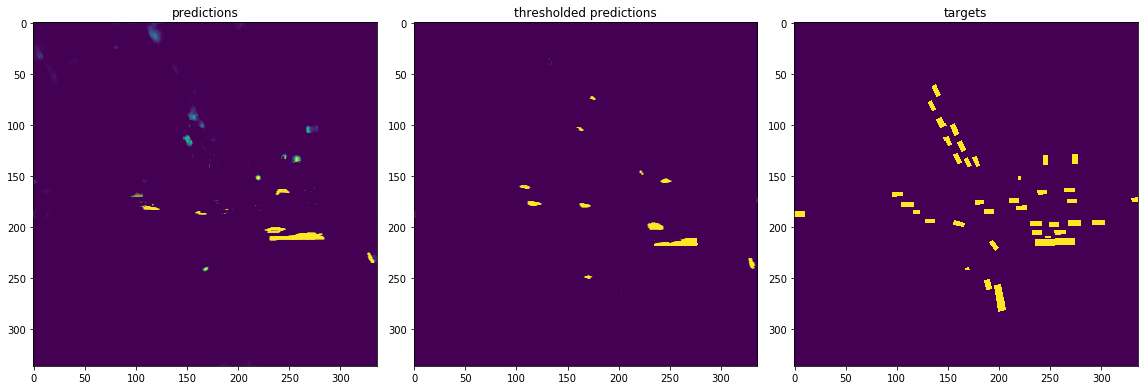

In [57]:
Image(filename='unet_cell_42_output_1.png')

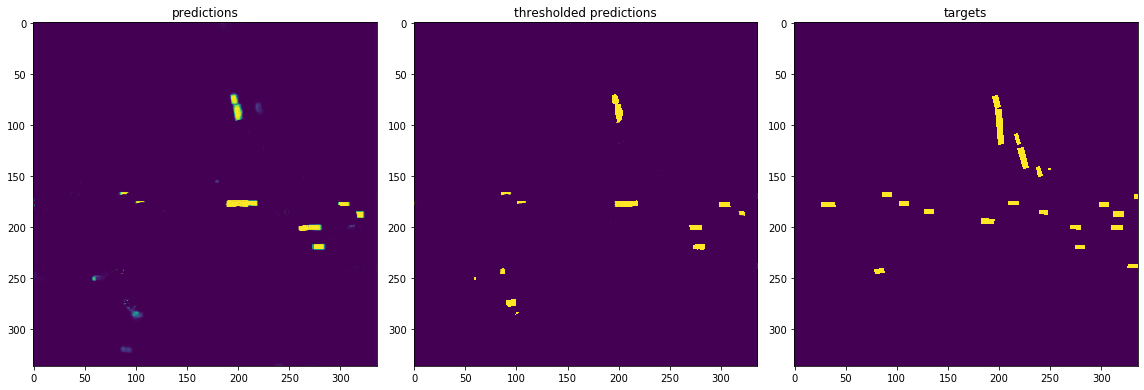

In [59]:
Image(filename='unet_cell_42_output_2.png')

As it seen above morphological operation, predicted objects are slightly worse by checking target values. The main reason is to working for training with limited data and number of epochs.

In [48]:
import json
gt = [b.serialize() for b in gt_box3ds]
pred = [b.serialize() for b in pred_box3ds]

In [49]:
with open(os.path.join(ARTIFACTS_FOLDER, "gt.json"), "w") as f:
    json.dump(gt, f)

with open(os.path.join(ARTIFACTS_FOLDER, "pred.json"), "w") as f:
    json.dump(pred, f)

In [52]:
!python ../home/keceli/eval/detection/mAP_evaluation.py --pred_file "./artifacts/pred.json" --gt_file "./artifacts/gt.json" --iou_threshold 0.4

Class_names =  ['animal', 'bicycle', 'bus', 'car', 'motorcycle', 'other_vehicle', 'pedestrian', 'truck']
Average per class mean average precision(mAP) =  0.0030458635369532
('animal', 0.0)
('bicycle', 0.0)
('bus', 0.00002812656778814)
('car', 0.009129450385127)
('motorcycle', 0.00002371318517606)
('other_vehicle', 0.00000443591886761)
('pedestrian', 0.000000353782829482)
('truck', 0.00000003256732867)


As we discuss in the above markdowns, mAP results are not capable to detect environment. Please refer other model notebook, which we have used pre-trained models which have been trained with modern gpus.